In [2]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import Normalize
import os
import sys
import torch
import torch.nn as nn

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import torch.nn as nn

class Discriminator(nn.Module):
    """
    Класс Discriminator представляет собой сверточную нейронную сеть, используемую для различения изображений.
    
    Аргументы:
    in_channels (int): Количество входных каналов. По умолчанию 4 (1 канал для источника и 3 канала для цели).
    
    Методы:
    __init__(self, in_channels=4): Инициализирует слои дискриминатора.
    forward(self, src, target): Выполняет прямое распространение через сеть. Объединяет входные изображения (src и target) по каналу и пропускает их через модель.
    
    Пример использования:
    discriminator = Discriminator()
    output = discriminator(src_image, target_image)
    """
    def __init__(self, in_channels=5):  # 2 channel source + 3 channels target
        super(Discriminator, self).__init__()
        def discriminator_block(in_channels, out_channels, stride):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),  # No BN in first layer
                nn.LeakyReLU(0.2, inplace=True)
            ]
            return layers

        self.model = nn.Sequential(
            # C64: 4x4 kernel, stride 2, padding 1
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # C128: 4x4 kernel, stride 2, padding 1
            *discriminator_block(64, 128, stride=2),

            # C256: 4x4 kernel, stride 2, padding 1
            *discriminator_block(128, 256, stride=2),

            # C512: 4x4 kernel, stride 1, padding 1
            *discriminator_block(256, 512, stride=1),

            # C1: 4x4 kernel, stride 1, padding 1
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),

            # Sigmoid activation
            nn.Sigmoid()
        )


    def forward(self, src, target):
        x = torch.cat((src, target), dim=1)
        return self.model(x)

if __name__ == '__main__':
    D = Discriminator()
    x = torch.randn(1, 2, 256, 256)
    target = torch.randn(1, 3, 256, 256)
    print(f'{x.shape} + {target.shape} -> {D(x, target).shape}')  # torch.Size([1, 1, 30, 30])


class UNetGenerator(nn.Module):
    def __init__(self, input_channels=2, output_channels=3):
        super(UNetGenerator, self).__init__()
        
        def encoder_block(in_channels, out_channels, use_bn=True):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            return nn.Sequential(*layers)

        def decoder_block(in_channels, out_channels, dropout=0):
            layers = [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels)
            ]
            if dropout != 0:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        def bottleneck_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
            )

        # Encoder
        self.enc1 = encoder_block(input_channels, 64, use_bn=False)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)
        self.enc5 = encoder_block(512, 512)
        self.enc6 = encoder_block(512, 512)
        self.enc7 = encoder_block(512, 512)

        self.bottleneck = bottleneck_block(512, 512)

        # Decoder
        self.dec1 = decoder_block(512, 512, dropout=0.5)
        self.dec2 = decoder_block(1024, 512, dropout=0.5)
        self.dec3 = decoder_block(1024, 512, dropout=0.5)
        self.dec4 = decoder_block(1024, 512)
        self.dec5 = decoder_block(1024, 256)
        self.dec6 = decoder_block(512, 128)
        self.dec7 = decoder_block(256, 64)
        self.final = nn.ConvTranspose2d(128, output_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        e7 = self.enc7(e6)

        b = self.bottleneck(e7)

        # Decoder + Skip connections
        d1 = self.dec1(b)
        d2 = self.dec2(torch.cat([d1, e7], dim=1))
        d3 = self.dec3(torch.cat([d2, e6], dim=1))
        d4 = self.dec4(torch.cat([d3, e5], dim=1))
        d5 = self.dec5(torch.cat([d4, e4], dim=1))
        d6 = self.dec6(torch.cat([d5, e3], dim=1))
        d7 = self.dec7(torch.cat([d6, e2], dim=1))
        return torch.tanh(self.final(torch.cat([d7, e1], dim=1)))

if __name__ == '__main__':
    G = UNetGenerator()
    x = torch.randn(1, 2, 256, 256)
    print(f'{x.shape} -> {G(x).shape}')  # torch.Size([1, 3, 256, 256])


class Pix2PixGAN:
    def __init__(self, device):
        self.device = device
        self.generator = UNetGenerator().to(self.device)
        self.discriminator = Discriminator().to(self.device)

        self.optimizer_G = torch.optim.AdamW(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.AdamW(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        self.criterion_GAN = nn.BCEWithLogitsLoss()
        self.criterion_L1 = nn.L1Loss()

    def train_step(self, real_A, real_B):
        real_A, real_B = real_A.to(self.device), real_B.to(self.device)

        # Train Discriminator
        self.optimizer_D.zero_grad()
        fake_B = self.generator(real_A)

        # Получаем выходные данные дискриминатора
        output_real = self.discriminator(real_A, real_B)
        output_fake = self.discriminator(real_A, fake_B.detach())

        # Создаем целевые метки того же размера, что и выходные данные дискриминатора
        target_real = torch.ones_like(output_real)
        target_fake = torch.zeros_like(output_fake)

        # Вычисляем потери
        loss_D_real = self.criterion_GAN(output_real, target_real)
        loss_D_fake = self.criterion_GAN(output_fake, target_fake)
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        self.optimizer_D.step()

        # Train Generator
        self.optimizer_G.zero_grad()
        loss_G_GAN = self.criterion_GAN(self.discriminator(real_A, fake_B), torch.ones_like(output_real))
        loss_G_L1 = self.criterion_L1(fake_B, real_B) * 100
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        self.optimizer_G.step()

        return loss_D.item(), loss_G.item()



torch.Size([1, 2, 256, 256]) + torch.Size([1, 3, 256, 256]) -> torch.Size([1, 1, 30, 30])
torch.Size([1, 2, 256, 256]) -> torch.Size([1, 3, 256, 256])


Using cpu
Чекпоинт успешно загружен: c:\Users\tiruu\OneDrive\Desktop\sar2opt\checkpoints/checkpoint_epoch_400.pth
Дата сохранения: 2024-12-20T14:20:29
Продолжаем обучение с эпохи 400
Файл с потерями не найден по пути: c:\Users\tiruu\OneDrive\Desktop\sar2opt/logs/losses.npz
torch.Size([3, 256, 256])


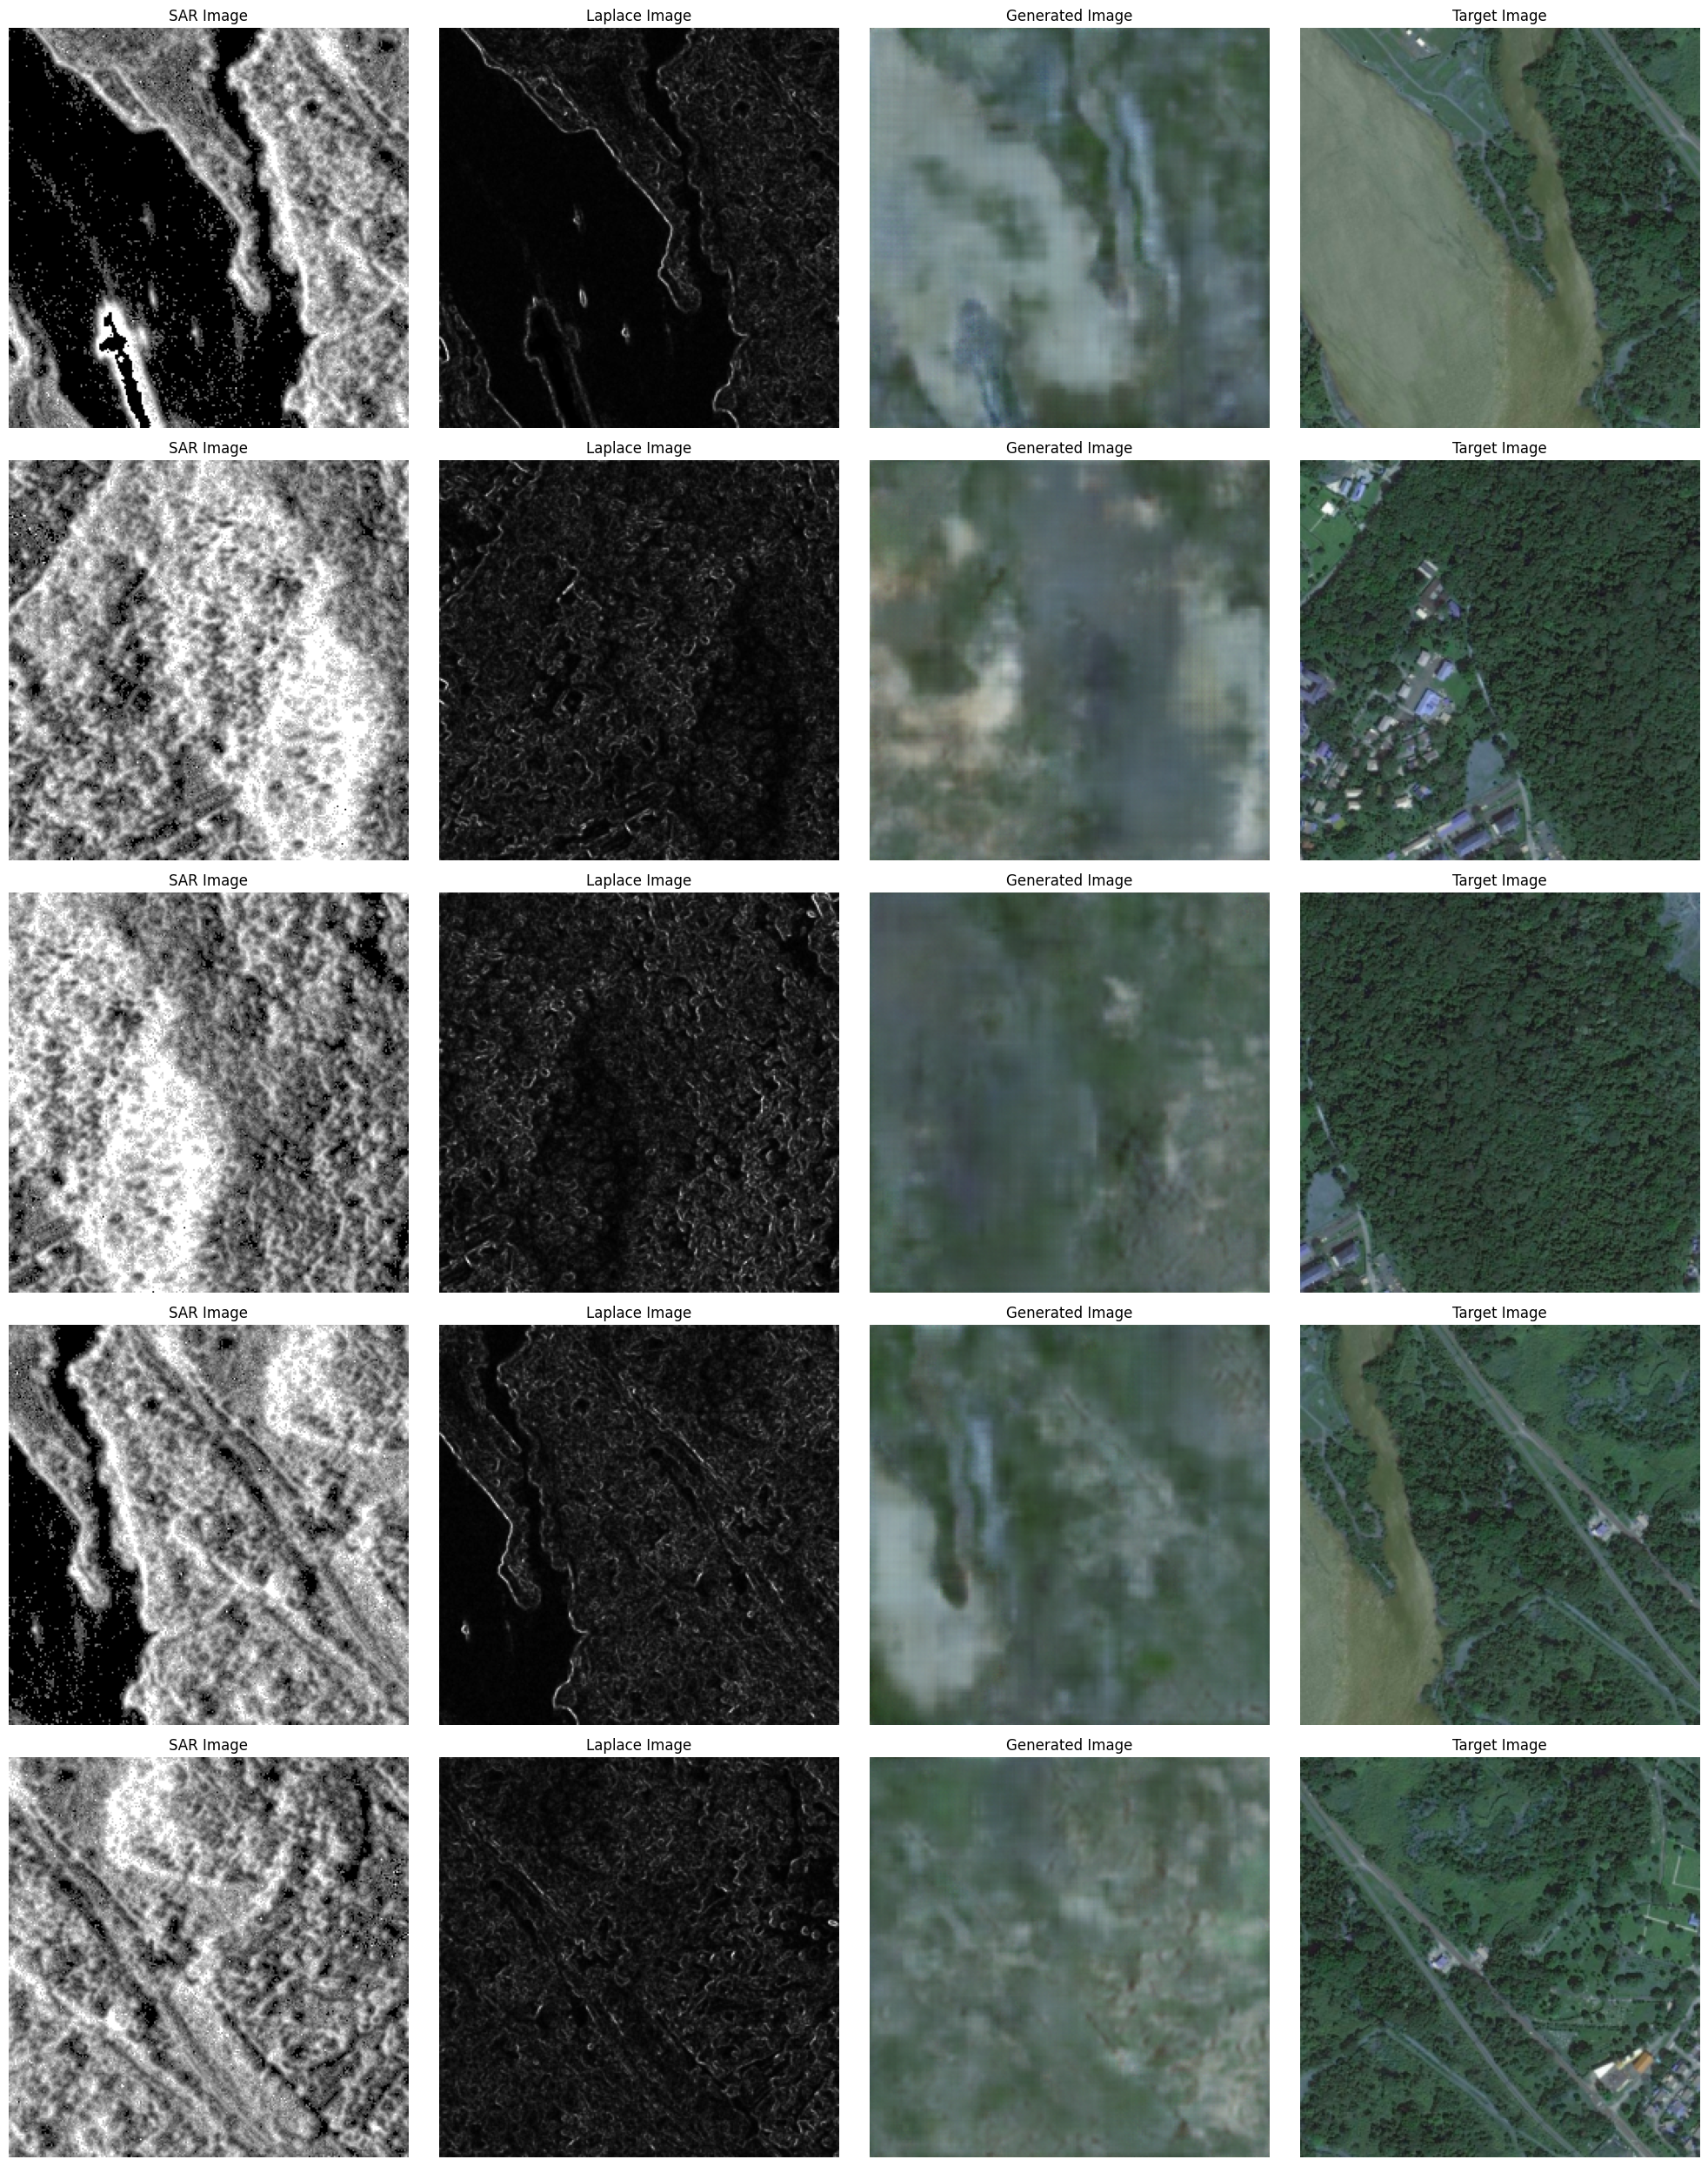

In [21]:
from utils.helpers import *
from utils.lossTracker import save_losses, load_losses
from utils.checkpointLogic import save_checkpoint, load_checkpoint
from tqdm.notebook import tqdm

device = torch.device("cpu") # torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print(f'Using {device}')
torch.cuda.empty_cache() if torch.cuda.is_available() else torch.mps.empty_cache() if torch.mps.is_available() else None
model = Pix2PixGAN(device)

start_epoch, loss_G, loss_D = load_checkpoint('checkpoint_epoch_400', model, device)
losses_dict = load_losses()
if losses_dict:
    g_loss = losses_dict['g_loss']
    d_loss = losses_dict['d_loss']
g_loss = []
d_loss = []

# Since this is an evaluation, we should use @torch.no_grad()
@torch.no_grad()
def run_model():
    for i, (sar, optical) in enumerate(test_loader):
        if i >= 5:
            break
        generated = model.generator(sar)
        break

    fig, axes = plt.subplots(5, 4, figsize=(20, 25))

    print(optical[i].shape)

    for i in range(5):
        sar_image = sar[i, 0, :, :].cpu().detach().numpy()
        laplace_image = sar[i, 1, :, :].cpu().detach().numpy()
        generated_image = generated[i].permute(1, 2, 0).cpu().detach().numpy()
        optical_image = optical[i].permute(1, 2, 0).cpu().detach().numpy()

        axes[i, 0].imshow(sar_image * 0.5 + 0.5, cmap='gray')
        axes[i, 0].set_title('SAR Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(laplace_image * 0.5 + 0.5, cmap='gray')
        axes[i, 1].set_title('Laplace Image')
        axes[i, 1].axis('off')

        axes[i, 2].imshow((generated_image * 0.5 + 0.5))
        axes[i, 2].set_title('Generated Image')
        axes[i, 2].axis('off')

        axes[i, 3].imshow((optical_image * 0.5 + 0.5))
        axes[i, 3].set_title('Target Image')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

run_model()

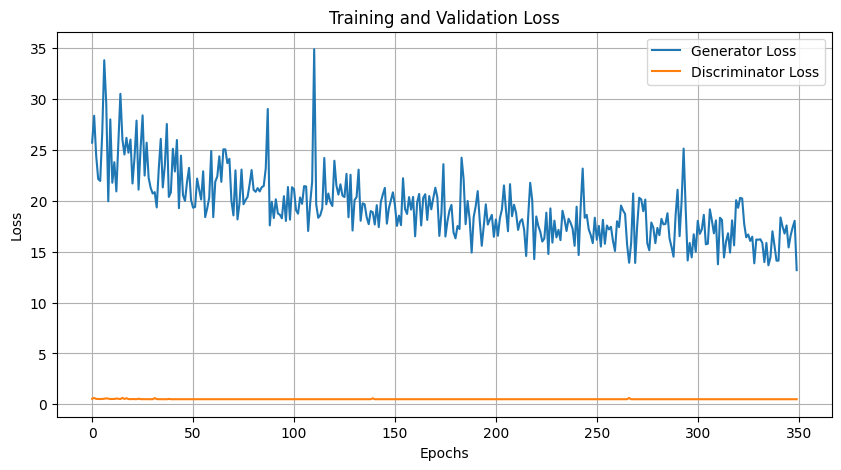

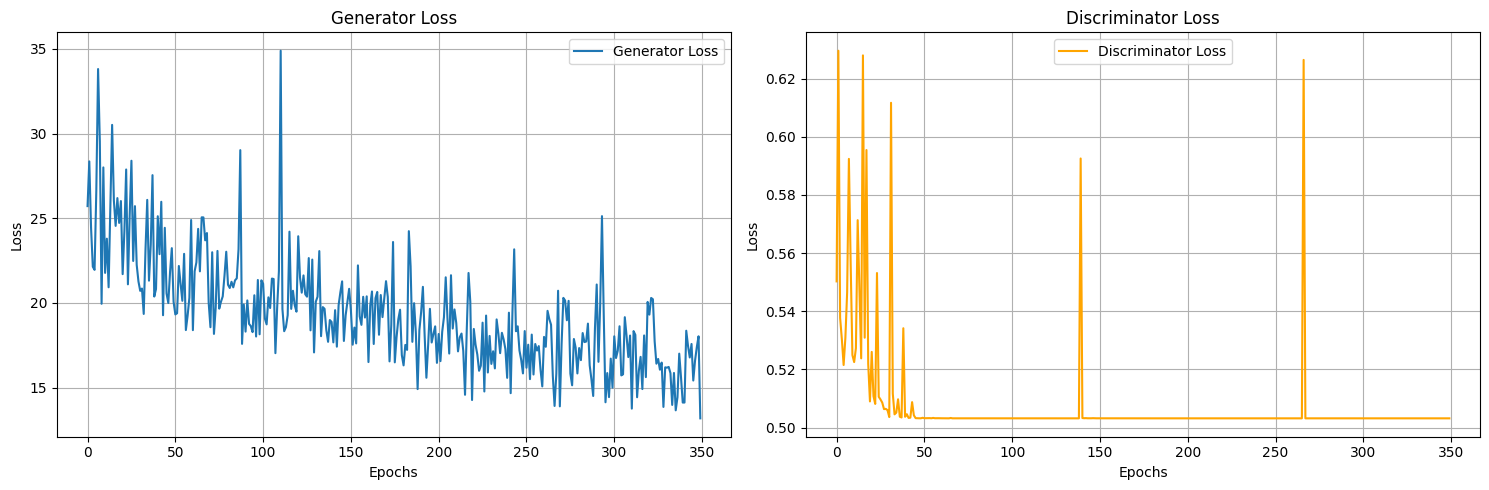

In [5]:
import numpy as np
import matplotlib.pyplot as plt

data  = np.load('./logs/losses.npz')
train_loss = data['train_losses']
val_loss = data['val_losses']

# Построение графиков
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Generator Loss')
plt.plot(val_loss, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



# Построение графиков с использованием subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График для Train Loss
axes[0].plot(train_loss, label='Generator Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Generator Loss')
axes[0].legend()
axes[0].grid(True)

# График для Validation Loss
axes[1].plot(val_loss, label='Discriminator Loss', color='orange')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Discriminator Loss')
axes[1].legend()
axes[1].grid(True)

# Отображение графиков
plt.tight_layout()
plt.show()
